In [13]:
!conda install -c conda-forge leidenalg --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /home/mohammed/anaconda3/envs/scarches-cl

  added / updated specs:
    - leidenalg


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arpack-3.7.0               |       hdefa2d7_2         215 KB  conda-forge
    ca-certificates-2022.9.24  |       ha878542_0         150 KB  conda-forge
    certifi-2022.9.24          |     pyhd8ed1ab_0         155 KB  conda-forge
    glpk-4.65                  |    h9202a9a_1004         1.0 MB  conda-forge
    igraph-0.9.8               |       hf5496dd_0         1.0 MB  conda-forge
    leidenalg-0.8.10           |   py37hd23a5d3_0         141 KB  conda-forge
    libblas-3.9.0              |   12_

In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2'] #Pancreas CelSeq, PancreasinDrop, Pancreas Fluidigm C1


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [7]:
# url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
# output = 'pancreas.h5ad'
# gdown.download(url, output, quiet=False)

In [8]:
adata_all = sc.read('pancreas.h5ad')

In [9]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
# source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata = adata[adata.obs['study'].isin(['Pancreas CelSeq2'])]
# target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_conditions
adata.obs

batch            study             cell_type  size_factors
index                                                               
0-0-0-0-0     0  Pancreas inDrop  Pancreas Endothelial       13073.0
1-0-0-0-0     0  Pancreas inDrop       Pancreas Acinar       17227.0
2-0-0-0-0     0  Pancreas inDrop       Pancreas Acinar        7844.0
3-0-0-0-0     0  Pancreas inDrop       Pancreas Acinar       10966.0
4-0-0-0-0     0  Pancreas inDrop  Pancreas Endothelial        8815.0
...         ...              ...                   ...           ...
2984-1        1     Pancreas SS2        Pancreas Gamma      221018.0
2985-1        1     Pancreas SS2        Pancreas Alpha      161140.0
2986-1        1     Pancreas SS2        Pancreas Delta      144527.0
2987-1        1     Pancreas SS2        Pancreas Alpha      125932.0
2988-1        1     Pancreas SS2        Pancreas Alpha       89241.0

[15681 rows x 4 columns]

In [10]:
adata_tasks = ['Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2','Pancreas inDrop'] #'Pancreas CelSeq2',

In [11]:
source_adata

View of AnnData object with n_obs × n_vars = 2426 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [12]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [13]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='ewc',
)

ewc is happening!
 |███████-------------| 35.2%  - val_loss: 748.2772827148 - val_recon_loss: 736.9939270020 - val_kl_loss: 12.8952775002 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |███████-------------| 36.6%  - val_loss: 743.2768859863 - val_recon_loss: 731.8010253906 - val_kl_loss: 12.6108164787 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
updating the task!
Saving best state of network...
Best State was in Epoch 161


In [14]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

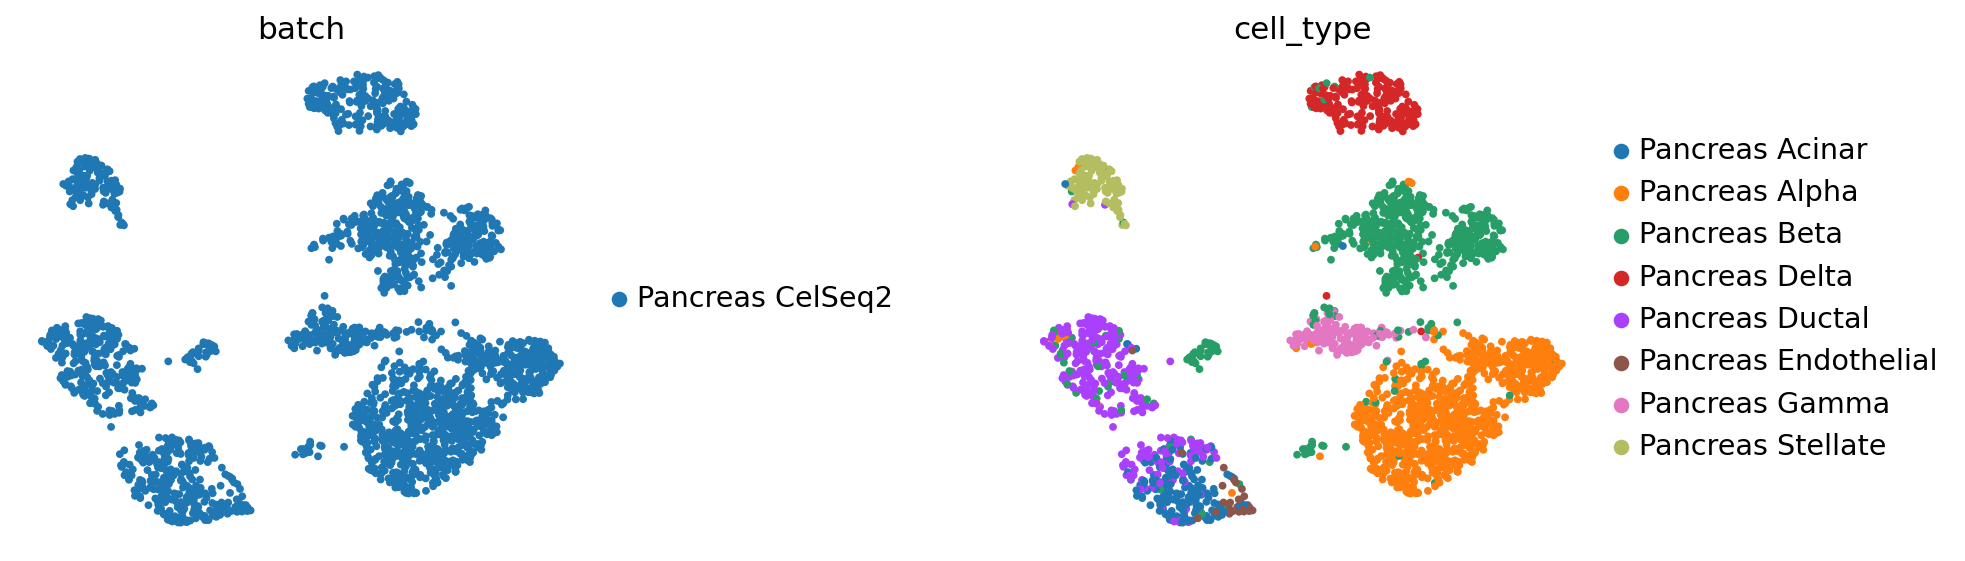

In [15]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [16]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [17]:
for ID, task in enumerate(adata_tasks, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID)
    task_i = adata[adata.obs[condition_key].isin([task])]
    new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'ewc',
                                                 model=ref_path)
    new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'ewc'
    )
    
    ref_path = 'reference_model/'#+ str (ID)
    new_trvae.save(ref_path, overwrite=True)

1
AnnData object with n_obs × n_vars = 1271 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 

ewc is happening!
 |████----------------| 20.0%  - val_loss: 568.9714355469 - val_recon_loss: 559.3631591797 - val_kl_loss: 19.4106216431 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |█████---------------| 28.0%  - val_loss: 571.8541870117 - val_recon_loss: 559.4079589844 - val_kl_loss: 17.9082489014 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |█████---------------| 29.4%  - val_loss: 572.0194702148 - val_recon_loss: 558.9956665039 - val_kl_loss: 17.8408164978 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong

In [18]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

In [19]:
# _adata = adata[~adata.obs[condition_key].isin(['Pancreas CelSeq2'])]
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))#adata.X, adata.obs[condition_key]
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obsm

AxisArrays with keys: 

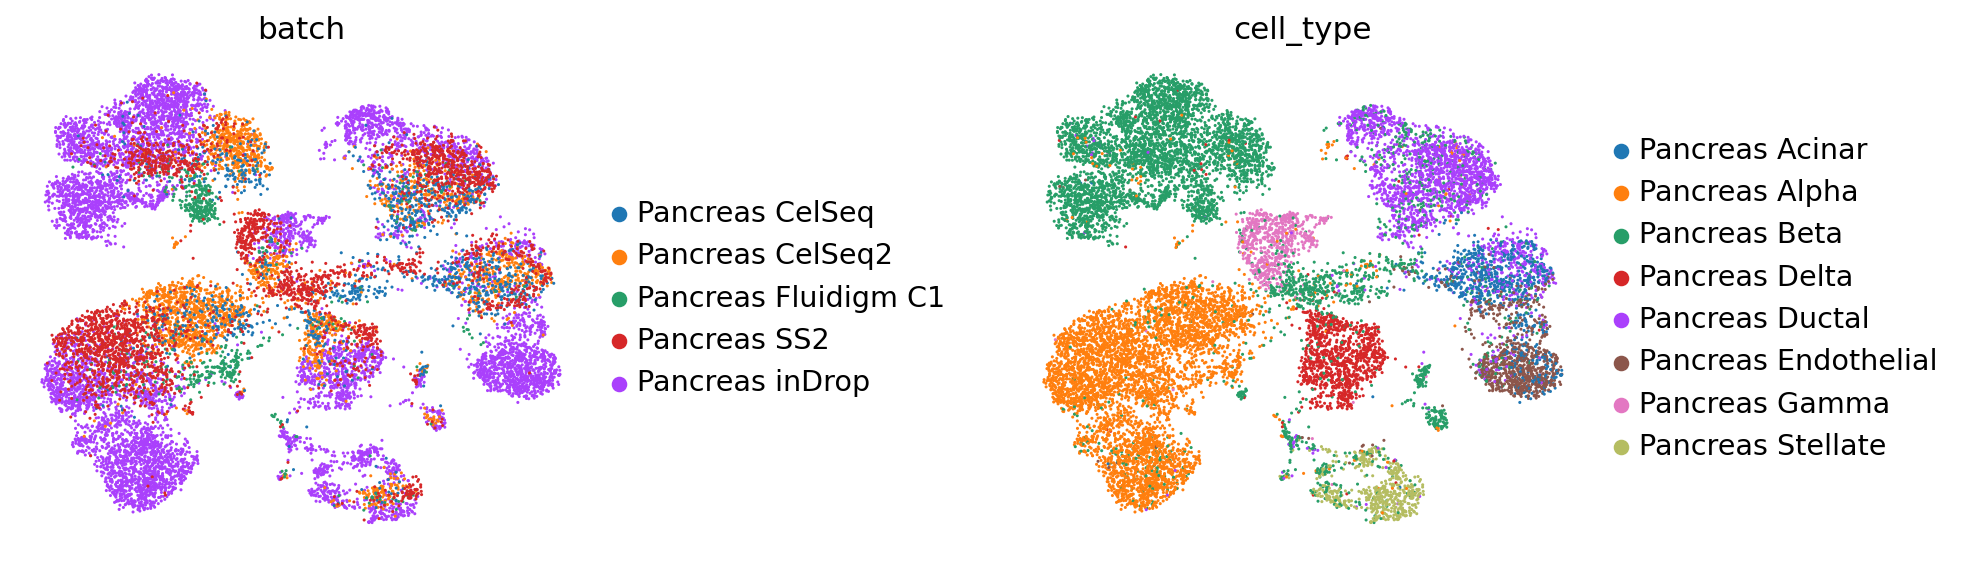

In [20]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [21]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:50:55


In [22]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'batch')
Bio_cons_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'cell_type')

Bio_cons_graph_conn_rehearsal,Batch_corr_graph_conn_rehearsal
#ewc 0.4
#(0.8064201093297406, 0.96950029045287)
#Bio_cons_graph_conn_onetenth=0.9726962958482419
#Batch_corr_graph_conn_onetenth=0.9048741734427915

#Bio_cons_graph_conn_oneseven=0.9745484517119338
#Batch_corr_graph_conn_ewc_oneseven=0.900851122200876

#Bio_cons_graph_conn_justone=0.9716943944998939
#Batch_corr_graph_conn_justone=0.8986872604637476

#Bio_cons_graph_conn_rehearsal=0.9719486957484479
#Batch_corr_graph_conn_rehearsal=0.7289319302023399

(0.9745484517119338, 0.900851122200876)

In [23]:
sc.tl.umap(adata_latent)
Batch_corr_ASW_rehearsal=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_rehearsal
#ew 0.4
# mean silhouette per group:                       silhouette_score
# group                                 
# Pancreas Acinar               0.736741
# Pancreas Alpha                0.770816
# Pancreas Beta                 0.781566
# Pancreas Delta                0.796581
# Pancreas Ductal               0.822017
# Pancreas Endothelial          0.687825
# Pancreas Gamma                0.768996
# Pancreas Stellate             0.759653
# 0.7655244790288251
#Batch_corr_ASW_onetenth=0.7700163313882914
#Batch_corr_ASW_oneseven=0.7677420977118364
#Batch_corr_ASW_justone=0.7864891512875769
#Batch_corr_ASW_rehearsal=0.8056815952195894

mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.739426
Pancreas Alpha                0.754574
Pancreas Beta                 0.786258
Pancreas Delta                0.809093
Pancreas Ductal               0.779026
Pancreas Endothelial          0.788454
Pancreas Gamma                0.736651
Pancreas Stellate             0.748455


0.7677420977118364

In [24]:
Bio_cons_ASW_rehearsal=scib.metrics.silhouette(adata_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_rehearsal
#ewc 0.4
# 0.6053410544991493
#Bio_cons_ASW_onetenth=0.6302791982889175
#Bio_cons_ASW_oneseven=0.6242425590753555
#Bio_cons_ASW_justone=0.6405854225158691
#Bio_cons_ASW_rehearsal=0.6806580275297165

0.6659413427114487

In [25]:
isolated_labels_rehearsal=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_rehearsal
#ewc 0.4
# Pancreas Acinar: 0.6085918854415274
# Pancreas Alpha: 0.9658803706823925
# Pancreas Beta: 0.840328569821087
# Pancreas Delta: 0.9542857142857143
# Pancreas Ductal: 0.8173030449492509
# Pancreas Endothelial: 0.7357575757575758
# Pancreas Gamma: 0.9332333083270817
# Pancreas Stellate: 0.8173147468818782
#isolated_labels_onetenth=0.8439304117951834
#isolated_labels_oneseven = 0.8430725908139767
#isolated_labels_justone=0.8312470266054668
#isolated_labels_rehearsal=0.8493131710683232

isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.6181211784324625


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.9602865269145687


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.8390584525284378


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.9622551361681796


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.8187106156083375


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


KeyboardInterrupt: 

In [ ]:
pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_justone
# pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate, embed=None, n_comps=50, scale=True, verbose=False)
#pcr_oneseven=0.02870146673652502
#pcr_onetenth=0.02870146673652502

In [ ]:
#                    'latent replay_1%': [],
#                    'latent replay_10%': [],
#                    'latent replay_50%': [],'Bio_cons_graph_conn'
#                    'latent replay_100%': [],

Bio_cons_graph_conn_onetenth=0.9726962958482419
Batch_corr_graph_conn_onetenth=0.9048741734427915

Bio_cons_graph_conn_onefourth=0.9726962958482419
Batch_corr_graph_conn_onefourth=0.9048741734427915

Bio_cons_graph_conn_oneseven=0.9745484517119338
Batch_corr_graph_conn_oneseven=0.900851122200876

Bio_cons_graph_conn_justone=0.9716943944998939
Batch_corr_graph_conn_justone=0.8986872604637476

Batch_corr_ASW_onetenth=0.7700163313882914
Batch_corr_ASW_onefourth=
Batch_corr_ASW_oneseven=0.7677420977118364
Batch_corr_ASW_justone=0.7864891512875769

Bio_cons_ASW_onetenth=0.6302791982889175
Bio_cons_ASW_onefourth=
Bio_cons_ASW_oneseven=0.6242425590753555
Bio_cons_ASW_justone=0.6405854225158691

isolated_labels_onetenth=0.8439304117951834
isolated_labels_onefourth=
isolated_labels_oneseven = 0.8430725908139767
isolated_labels_justone=0.8312470266054668

time_onetenth = 
time_onfourth=
time_oneseven = 0:48:17
time_justone = 
import pandas as pd
methods_metrics = {'Surgery': [0.84,0.66,0.97,0.80,0.76], 
                   'ewc_0.1': [isolated_labels_onetenth, Bio_cons_ASW_onetenth, Bio_cons_graph_conn_onetenth, 
                               Batch_corr_ASW_onetenth, Batch_corr_graph_conn_onetenth],
                   'ewc_0.4': [0.82,0.65,0.97,0.79,0.85], #[0.82,0.65,0.97,0.79,0.85]
                   'ewc_0.7':[isolated_labels_oneseven, Bio_cons_ASW_oneseven, Bio_cons_graph_conn_oneseven, 
                              Batch_corr_ASW_oneseven, Batch_corr_graph_conn_oneseven],
                   'ewc_1': [isolated_labels_justone, Bio_cons_ASW_justone, Bio_cons_graph_conn_justone, 
                               Batch_corr_ASW_justone, Batch_corr_graph_conn_justone], 
                   'rehearsal': [isolated_labels_rehearsal, Bio_cons_ASW_rehearsal, Bio_cons_graph_conn_rehearsal, 
                               Batch_corr_ASW_rehearsal, Batch_corr_graph_conn_rehearsal]} #[0.85,0.68,0.97,0.82,0.73]
index = ['isolated_labels','Bio_cons_ASW', 'Bio_cons_graph_conn', 'Batch_corr_ASW','Batch_corr_graph_conn']
methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
methods_metrics_df

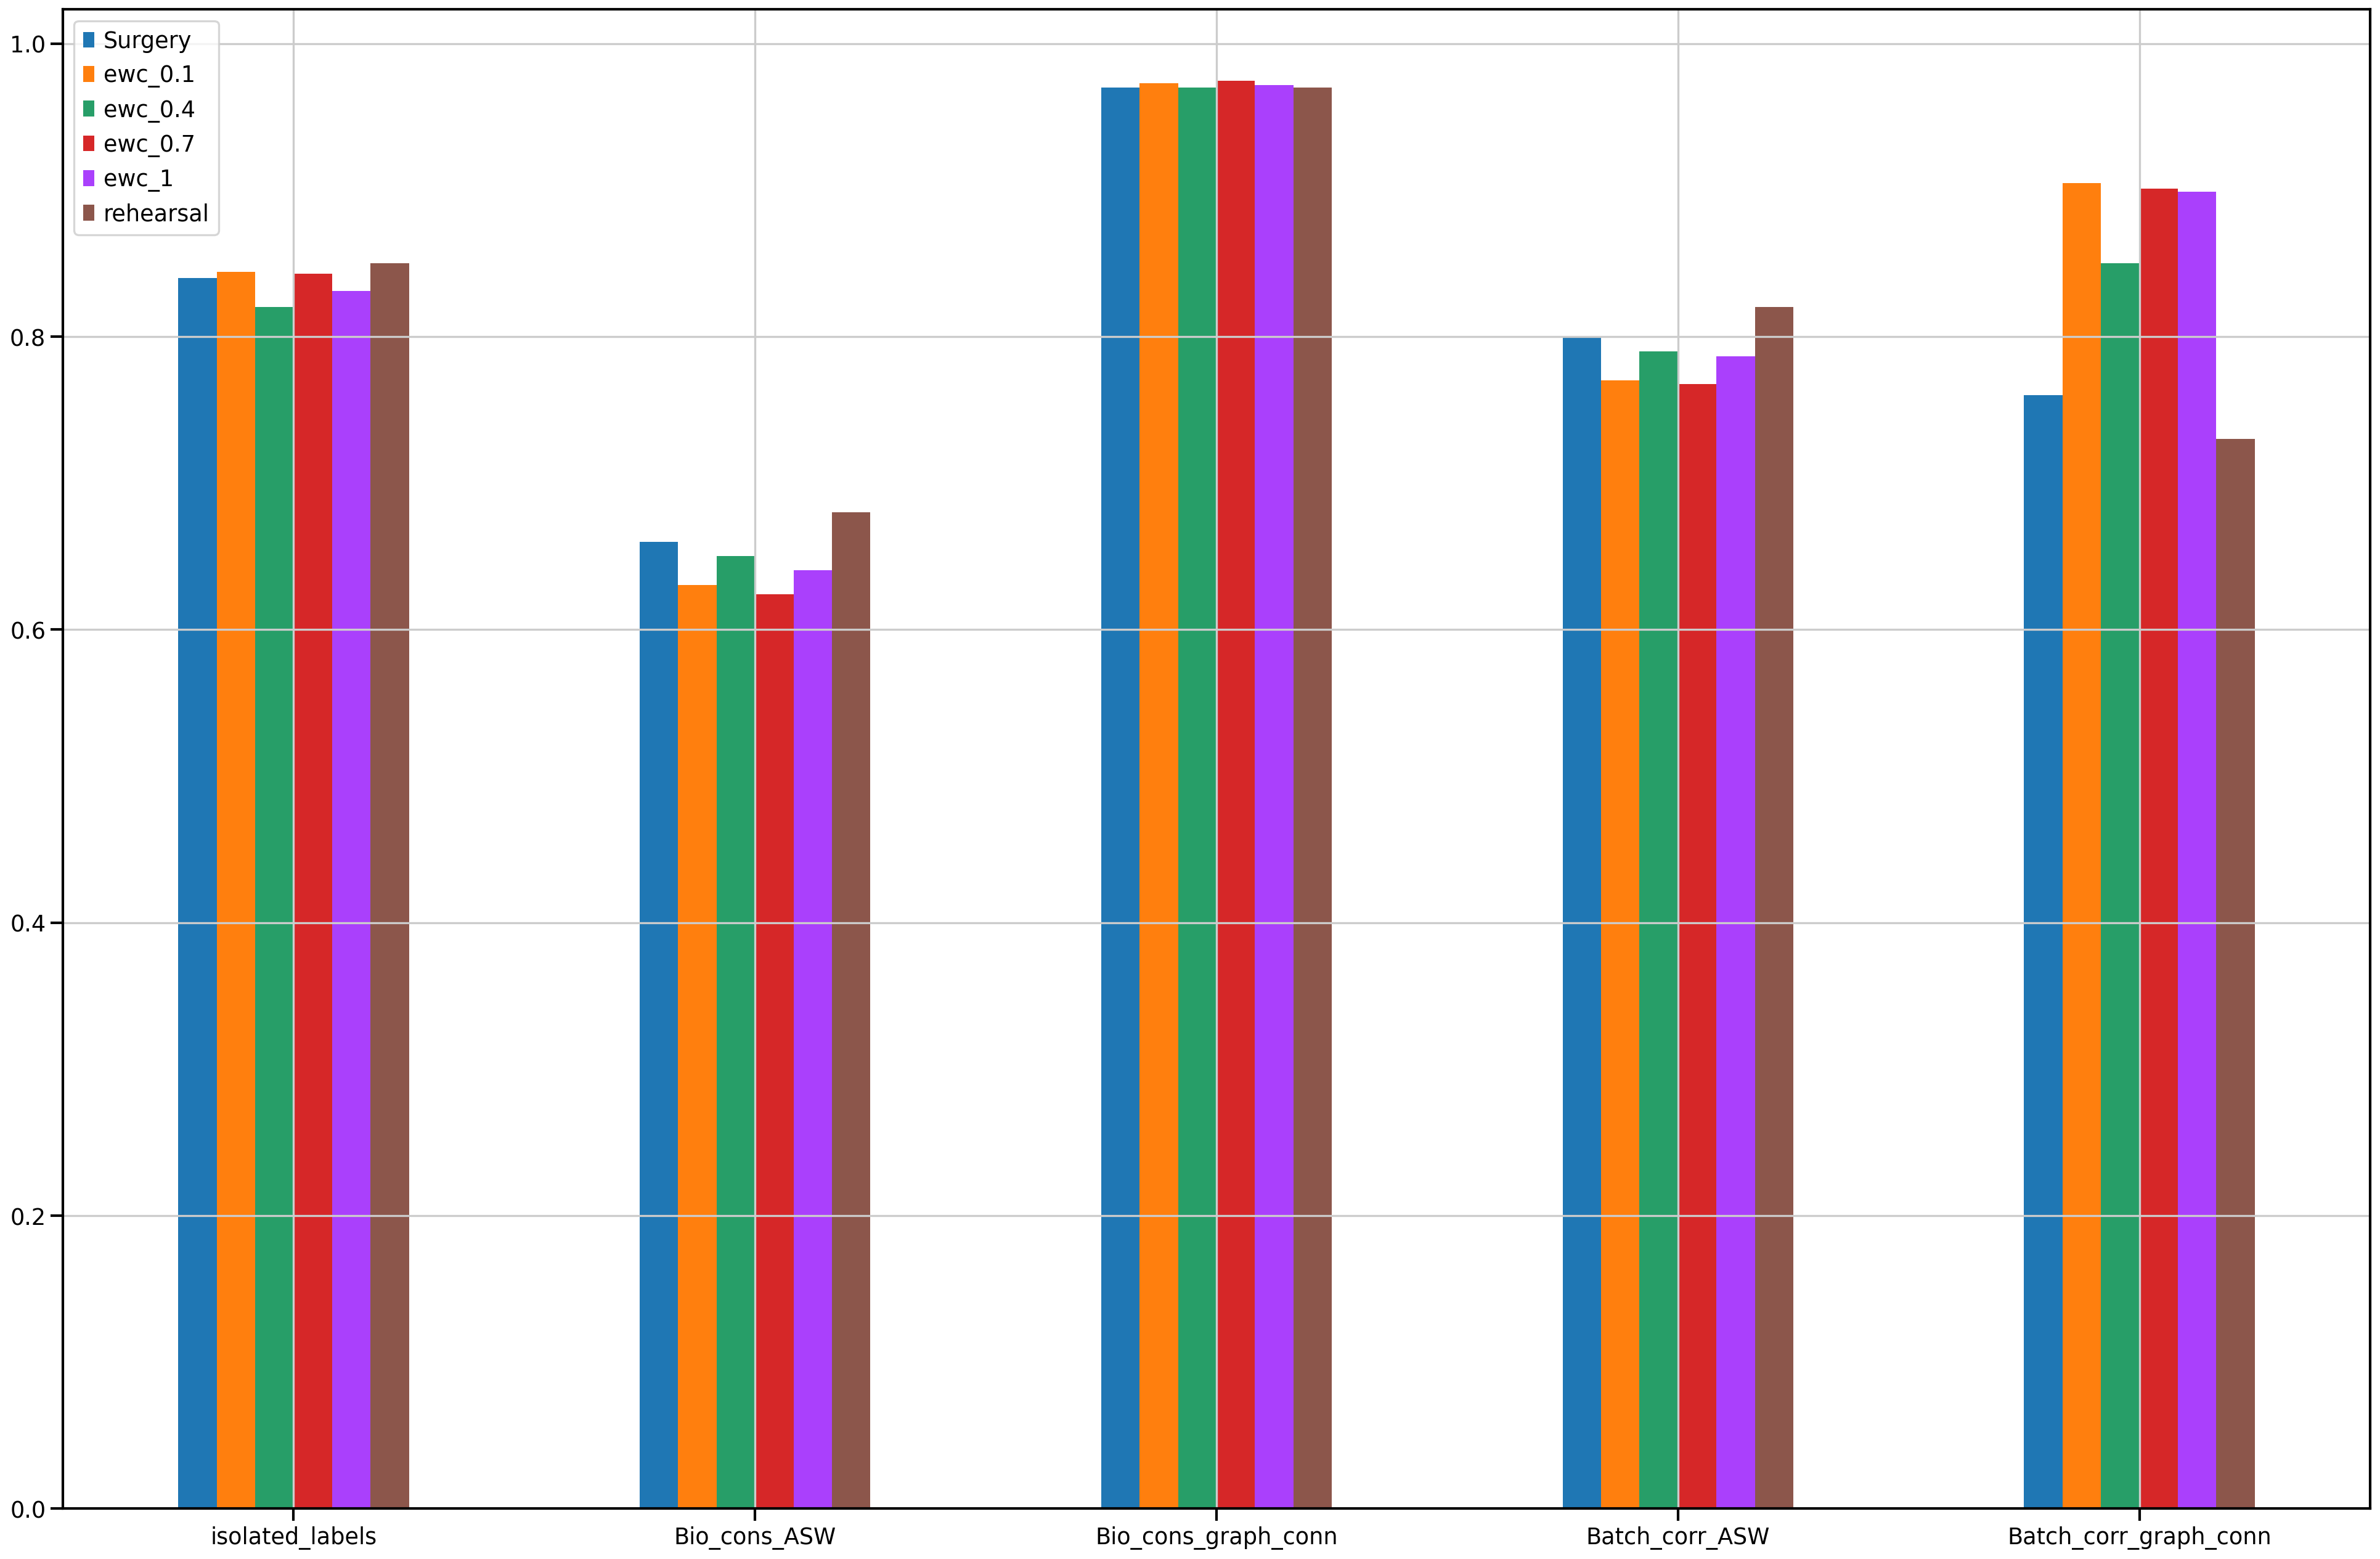

In [30]:
ax = methods_metrics_df.plot.bar(rot=0, figsize = (30,20))

In [ ]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    learning_approach = 'ewc'
)

In [67]:
# task_i_after.obs['cell_type'] = adata[adata.obs['study'].isin(['Pancreas SS2'])].obs[cell_type_key].tolist()
# task_i_after.obs['batch'] = adata[adata.obs['study'].isin(['Pancreas SS2'])].obs[condition_key].tolist()

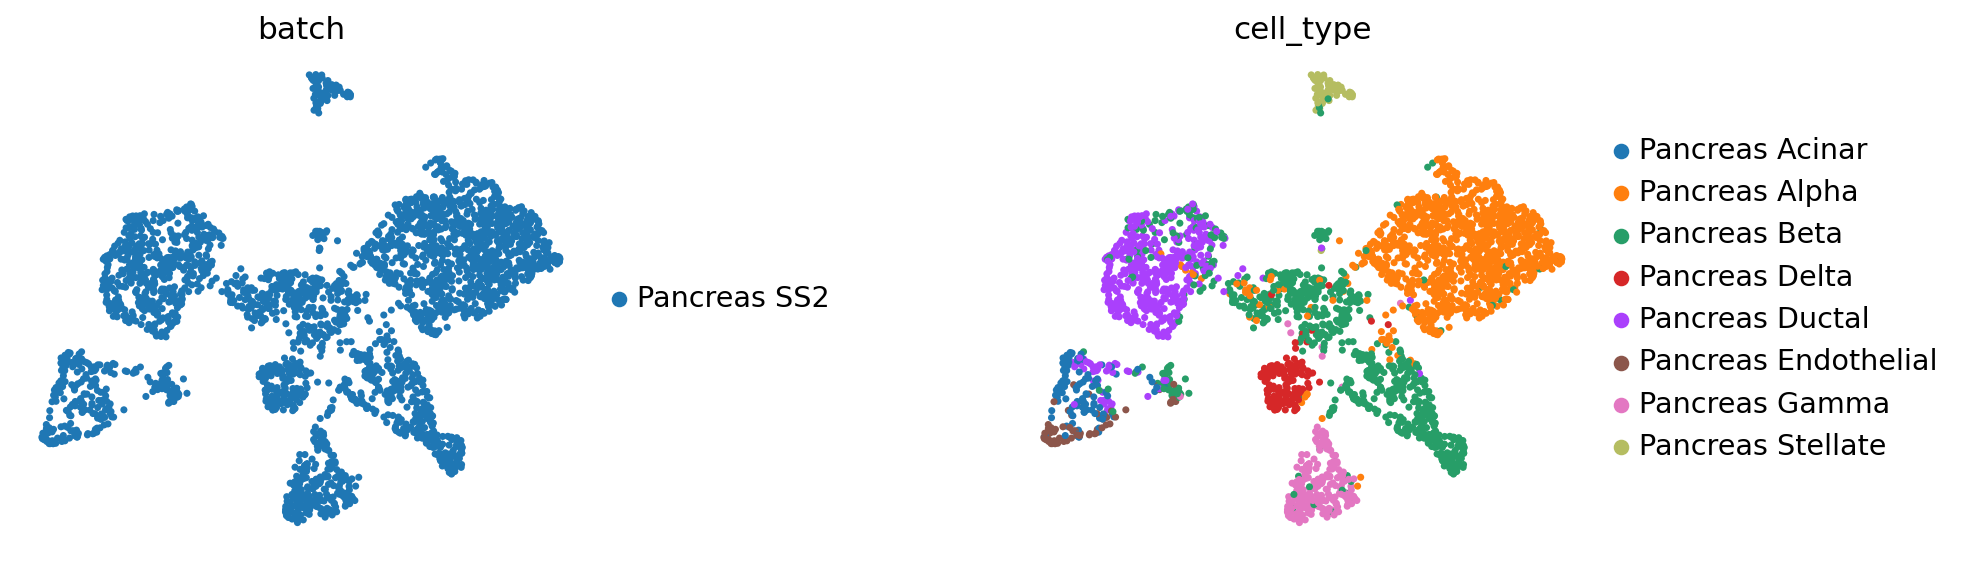

In [68]:
# sc.pp.neighbors(task_i_after, n_neighbors=8)
# sc.tl.leiden(task_i_after)
# sc.tl.umap(task_i_after)
# sc.pl.umap(task_i_after,
#            color=['batch', 'cell_type'],
#            frameon=False,
#            wspace=0.6,
#            )

In [48]:
len(task_i_latent)
cat_task_i_latent = np.concatenate((task_i_latent), axis=None)
#print(cat_task_i_latent.shape)
cat_task_i_latent_reshaped = cat_task_i_latent.reshape(15681,10)
print(cat_task_i_latent_reshaped.shape)
len(cat_task_i_latent)

(15681, 10)


156810

In [49]:
all_back_adata = sc.AnnData(cat_task_i_latent_reshaped)
all_back_adata

AnnData object with n_obs × n_vars = 15681 × 10

In [50]:
# for ID, task in enumerate(adata_tasks):
#     print(ID)
#     task_i = adata[adata.obs['study'].isin([task])]
#adata_latent = sc.AnnData(trvae.get_latent())
adata_latent = sc.AnnData(task_i_latent)
adata_latent.obs['cell_type'] = adata[adata.obs['study'].isin(['Pancreas inDrop'])].obs[cell_type_key].tolist()
adata_latent.obs['batch'] = adata[adata.obs['study'].isin(['Pancreas inDrop'])].obs[condition_key].tolist()

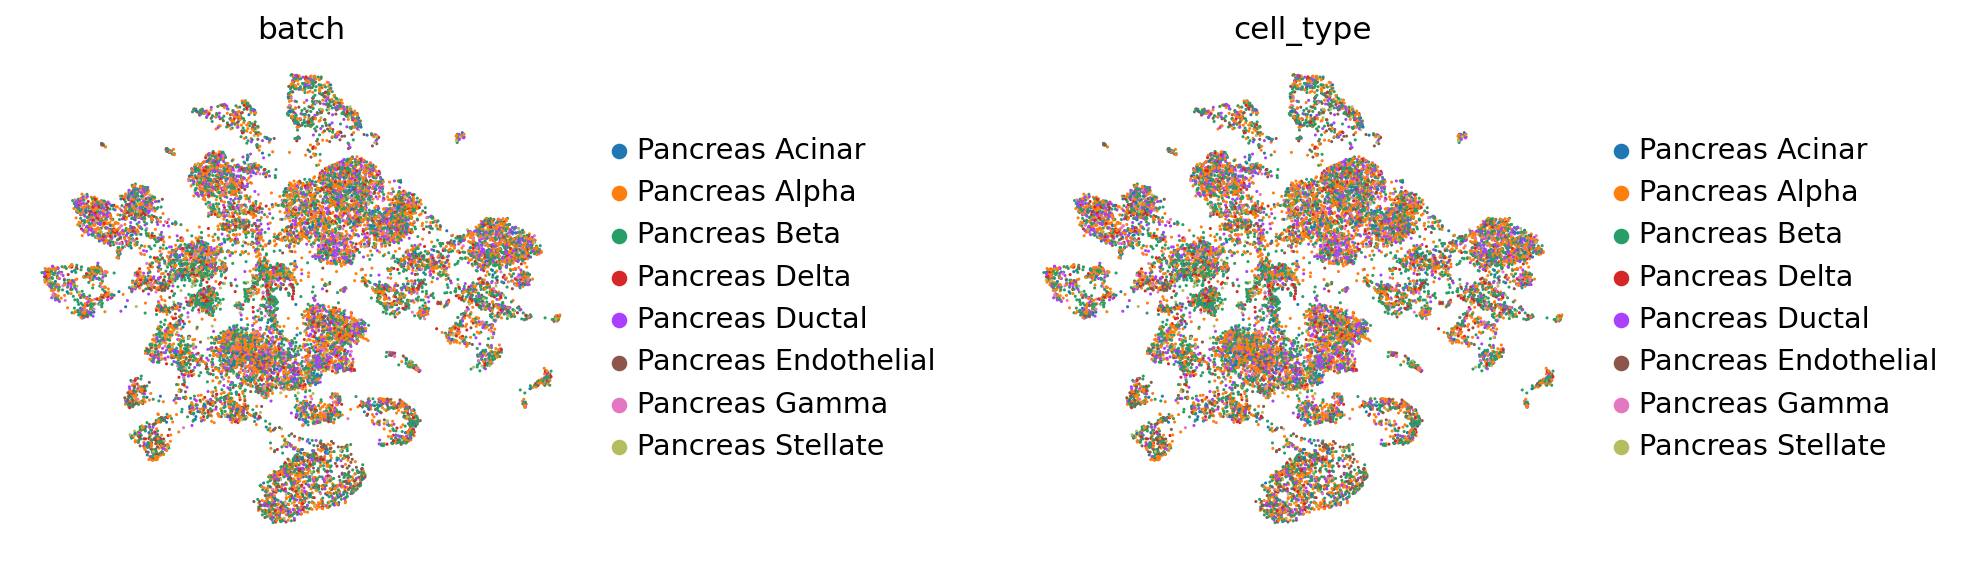

In [51]:
sc.pp.neighbors(all_back_adata, n_neighbors=8)
sc.tl.leiden(all_back_adata)
sc.tl.umap(all_back_adata)
sc.pl.umap(all_back_adata,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obsm

In [16]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    learning_approach = 'ewc'
)

ewc is happening!


ValueError: need at least one array to concatenate

In [12]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

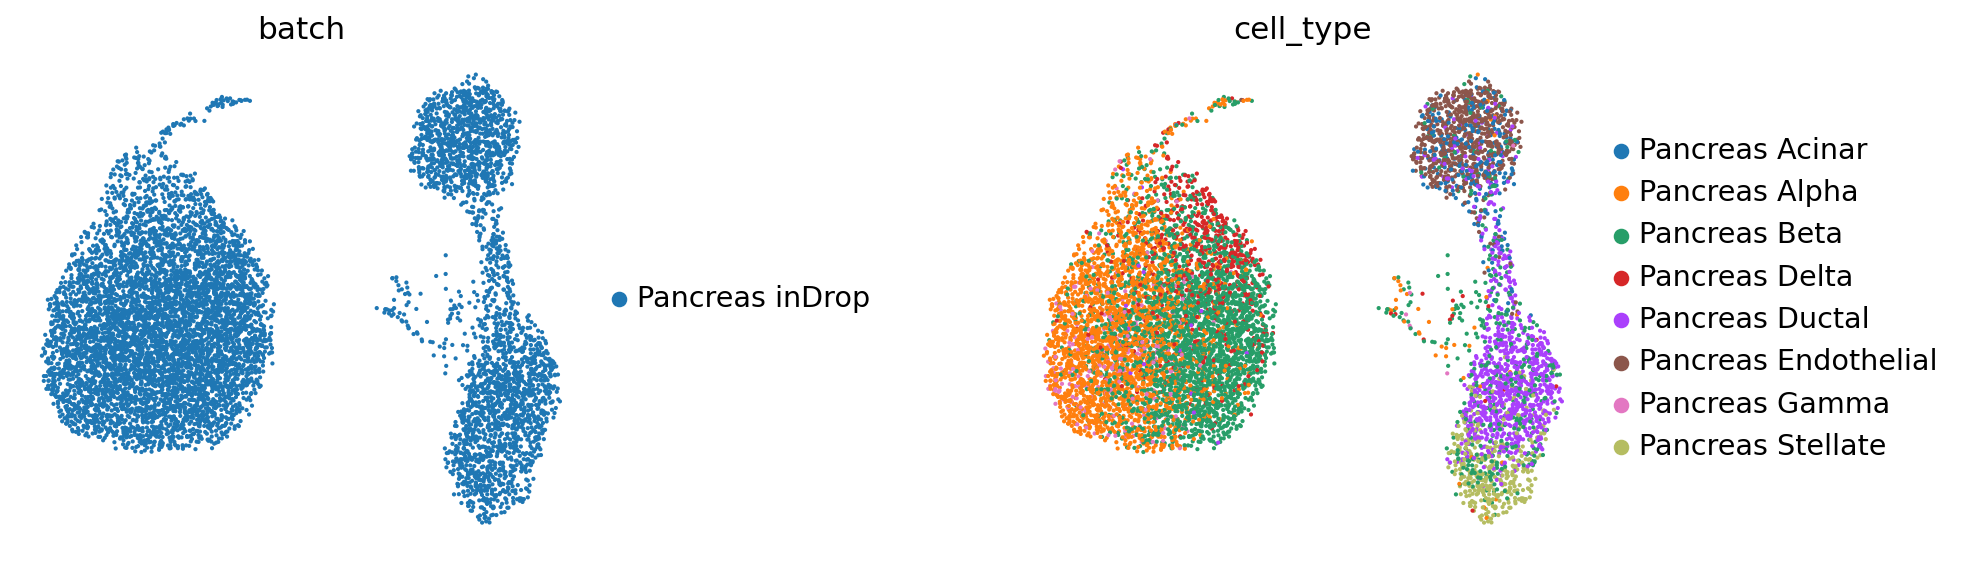

In [13]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [14]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [15]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata,
                                             learning_approach = 'new ewc',
                                             model_cl=ref_path)

AnnData object with n_obs × n_vars = 2426 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [16]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0,
    learning_approach = 'new ewc'
    
)

new ewc is happening!
fisher:  torch.Size([1000, 1])
optpar:  torch.Size([1000, 1])
param:  Parameter containing:
tensor([[-1.178, -1.708],
        [-1.193,  1.380],
        [-0.302,  1.299],
        [-0.487, -1.165],
        [ 0.799, -0.639],
        [ 0.637,  0.299],
        [-0.369, -1.251],
        ...,
        [ 0.333, -1.392],
        [-0.617, -0.797],
        [-0.221,  0.121],
        [-1.027, -0.100],
        [ 1.427, -0.466],
        [ 0.090, -1.591],
        [-0.616,  0.182]], device='cuda:0', requires_grad=True)
fisher:  torch.Size([128, 1000])
optpar:  torch.Size([128, 1000])
param:  Parameter containing:
tensor([[     0.016,     -0.013,     -0.010,     -0.010,      0.012,     -0.018,
             -0.009,  ...,      0.023,     -0.017,      0.026,     -0.021,
              0.008,      0.018,      0.003],
        [    -0.001,      0.013,     -0.024,     -0.025,     -0.033,     -0.024,
             -0.003,  ...,     -0.007,      0.009,      0.000,     -0.011,
              0.0

param:  Parameter containing:
tensor([     0.081,     -0.054,      0.014,     -0.015,     -0.030,      0.070,
            -0.087,      0.098,      0.065,     -0.036,      0.023,      0.071,
            -0.006,     -0.030,     -0.003,     -0.019,      0.016,     -0.031,
             0.078,     -0.092,      0.038,     -0.002,      0.033,      0.030,
             0.070,      0.039,     -0.035,     -0.091,      0.026,     -0.070,
            -0.046,     -0.106,      0.104,     -0.034,     -0.003,      0.026,
            -0.009,     -0.008,     -0.077,     -0.021,     -0.009,     -0.126,
            -0.096,      0.075,     -0.022,      0.018,     -0.011,     -0.009,
            -0.028,     -0.027,     -0.105,     -0.051,      0.104,     -0.069,
             0.075,     -0.060,     -0.036,      0.053,     -0.046,     -0.082,
            -0.051,     -0.100,      0.025,     -0.076,      0.102,     -0.057,
            -0.031,     -0.056,      0.034,     -0.055,     -0.007,      0.016,
          

param:  Parameter containing:
tensor([[     0.249,      0.705],
        [     0.199,      0.583],
        [    -0.241,      0.428],
        [     0.149,     -0.430],
        [    -0.151,      0.494],
        [    -0.757,     -0.024],
        [     0.744,     -0.104],
        [    -0.812,     -0.144],
        [    -0.563,     -0.020],
        [     0.698,     -0.149],
        [    -0.644,      0.298],
        [     0.176,     -0.600],
        [     0.671,     -0.683],
        [     0.322,     -0.694],
        [    -0.586,      0.568],
        [     0.834,     -0.656],
        [     0.513,     -0.292],
        [    -0.072,     -0.363],
        [     0.022,      0.167],
        [    -0.300,      0.282],
        [     0.167,     -0.451],
        [     0.492,     -0.456],
        [     0.626,     -0.082],
        [     0.386,      0.212],
        [     0.496,     -0.000],
        [    -0.490,      0.029],
        [    -0.858,     -0.192],
        [    -0.437,     -0.248],
        [    -0.28

param:  Parameter containing:
tensor([[ 0.046,  0.072,  0.035, -0.027, -0.036,  0.009, -0.057,  ..., -0.068,
          0.060, -0.066, -0.086,  0.057, -0.086,  0.070],
        [-0.074, -0.007,  0.061,  0.033,  0.080,  0.004,  0.009,  ...,  0.032,
         -0.064, -0.073,  0.070,  0.078, -0.044, -0.014],
        [-0.073,  0.079,  0.029, -0.037,  0.013, -0.005,  0.012,  ..., -0.033,
          0.051, -0.079, -0.020, -0.018,  0.064,  0.071],
        [ 0.058,  0.083,  0.080, -0.012, -0.001,  0.062, -0.005,  ...,  0.077,
          0.094, -0.002, -0.013, -0.026,  0.080, -0.050],
        [ 0.002, -0.005,  0.005, -0.010,  0.025, -0.037,  0.072,  ..., -0.038,
         -0.020,  0.006,  0.012, -0.042,  0.012, -0.090],
        [-0.018,  0.030,  0.008,  0.073,  0.089,  0.064, -0.012,  ..., -0.044,
         -0.094,  0.008, -0.057, -0.011, -0.023,  0.068],
        [-0.031,  0.026, -0.005, -0.021,  0.040,  0.012, -0.058,  ...,  0.000,
         -0.031,  0.042, -0.007,  0.024,  0.074,  0.040],
        ...

fisher:  torch.Size([1000, 1])
optpar:  torch.Size([1000, 1])
param:  Parameter containing:
tensor([[-1.178, -1.709],
        [-1.193,  1.375],
        [-0.302,  1.294],
        [-0.487, -1.169],
        [ 0.799, -0.644],
        [ 0.637,  0.294],
        [-0.369, -1.255],
        ...,
        [ 0.333, -1.396],
        [-0.617, -0.792],
        [-0.221,  0.116],
        [-1.027, -0.104],
        [ 1.427, -0.469],
        [ 0.090, -1.588],
        [-0.616,  0.178]], device='cuda:0', requires_grad=True)
fisher:  torch.Size([128, 1000])
optpar:  torch.Size([128, 1000])
param:  Parameter containing:
tensor([[ 0.014, -0.015, -0.012, -0.012,  0.010, -0.018, -0.008,  ...,  0.023,
         -0.017,  0.028, -0.021,  0.008,  0.019,  0.003],
        [-0.002,  0.011, -0.026, -0.026, -0.035, -0.022, -0.001,  ..., -0.007,
          0.009,  0.002, -0.011,  0.015, -0.021,  0.022],
        [ 0.022, -0.015,  0.024,  0.024,  0.000,  0.016,  0.020,  ...,  0.026,
          0.006, -0.011,  0.013,  0.011, -0.

param:  Parameter containing:
tensor([[-0.030, -0.052,  0.002,  0.031,  0.046, -0.069, -0.036,  ..., -0.047,
          0.086,  0.077, -0.069,  0.079,  0.070, -0.017],
        [-0.030, -0.041, -0.076, -0.065,  0.023, -0.084,  0.064,  ...,  0.033,
          0.070, -0.075,  0.005, -0.026, -0.026, -0.048],
        [-0.015, -0.013, -0.084,  0.038,  0.038, -0.013,  0.038,  ...,  0.010,
         -0.013,  0.037, -0.003, -0.009, -0.105, -0.024],
        [-0.089, -0.013, -0.094,  0.038,  0.046,  0.039, -0.025,  ..., -0.047,
         -0.037,  0.039, -0.051, -0.034, -0.002, -0.040],
        [ 0.034, -0.013, -0.065, -0.055, -0.035, -0.059, -0.018,  ...,  0.019,
          0.074,  0.008, -0.057, -0.011,  0.069, -0.003],
        [ 0.030, -0.064,  0.005,  0.090, -0.011,  0.067,  0.076,  ..., -0.080,
          0.027, -0.064,  0.075, -0.102,  0.041, -0.018],
        [-0.101,  0.002, -0.058,  0.024, -0.079, -0.039,  0.078,  ...,  0.012,
          0.025,  0.115, -0.041,  0.108,  0.067,  0.060],
        [-0

param:  Parameter containing:
tensor([[ 0.092, -0.040,  0.085,  0.031, -0.055, -0.074, -0.050,  ...,  0.033,
          0.037,  0.078, -0.019, -0.049,  0.007, -0.013],
        [ 0.120,  0.071, -0.018,  0.055,  0.030, -0.000, -0.047,  ...,  0.012,
          0.090,  0.001,  0.003, -0.083, -0.035, -0.002],
        [ 0.001,  0.067,  0.091,  0.057, -0.033, -0.024,  0.027,  ..., -0.060,
         -0.032,  0.103, -0.058,  0.115,  0.077,  0.018],
        [ 0.009,  0.079,  0.035,  0.043, -0.056, -0.060,  0.063,  ..., -0.053,
          0.060,  0.049, -0.004, -0.054, -0.016,  0.059],
        [ 0.047,  0.028,  0.016, -0.044,  0.028, -0.051, -0.016,  ..., -0.048,
          0.082,  0.023,  0.016, -0.104, -0.021,  0.066],
        [ 0.105, -0.066, -0.034,  0.046,  0.003,  0.046, -0.058,  ...,  0.074,
          0.045, -0.093,  0.040, -0.059, -0.052,  0.058],
        [ 0.087,  0.008,  0.019,  0.009, -0.044,  0.050, -0.045,  ..., -0.081,
          0.045, -0.067, -0.010, -0.106,  0.021,  0.087],
        ...

param:  Parameter containing:
tensor([     0.080,     -0.061,      0.011,     -0.009,     -0.024,      0.068,
            -0.093,      0.091,      0.057,     -0.044,      0.031,      0.079,
            -0.013,     -0.038,     -0.010,     -0.026,      0.008,     -0.039,
             0.070,     -0.084,      0.031,     -0.009,      0.026,      0.032,
             0.064,      0.042,     -0.039,     -0.084,      0.034,     -0.063,
            -0.047,     -0.099,      0.098,     -0.035,     -0.010,      0.020,
            -0.001,     -0.000,     -0.069,     -0.013,     -0.003,     -0.124,
            -0.090,      0.067,     -0.022,      0.011,     -0.008,     -0.017,
            -0.035,     -0.027,     -0.111,     -0.057,      0.110,     -0.064,
             0.068,     -0.055,     -0.044,      0.054,     -0.043,     -0.074,
            -0.046,     -0.108,      0.030,     -0.079,      0.095,     -0.064,
            -0.030,     -0.058,      0.039,     -0.061,     -0.015,      0.012,
          

fisher:  torch.Size([1000, 1])
optpar:  torch.Size([1000, 1])
param:  Parameter containing:
tensor([[-1.178, -1.710],
        [-1.193,  1.370],
        [-0.302,  1.289],
        [-0.487, -1.173],
        [ 0.799, -0.647],
        [ 0.637,  0.289],
        [-0.369, -1.259],
        ...,
        [ 0.333, -1.399],
        [-0.617, -0.788],
        [-0.221,  0.111],
        [-1.027, -0.108],
        [ 1.427, -0.473],
        [ 0.090, -1.584],
        [-0.616,  0.176]], device='cuda:0', requires_grad=True)
fisher:  torch.Size([128, 1000])
optpar:  torch.Size([128, 1000])
param:  Parameter containing:
tensor([[     0.012,     -0.017,     -0.014,     -0.014,      0.008,     -0.019,
             -0.009,  ...,      0.023,     -0.019,      0.028,     -0.022,
              0.008,      0.019,      0.001],
        [    -0.005,      0.010,     -0.028,     -0.029,     -0.037,     -0.023,
             -0.003,  ...,     -0.007,      0.007,      0.002,     -0.011,
              0.015,     -0.021,      0

param:  Parameter containing:
tensor([[ 0.016,  0.044,  0.028,  0.030, -0.025, -0.068,  0.047,  ..., -0.046,
          0.015, -0.065, -0.041,  0.033,  0.059, -0.006],
        [ 0.058,  0.040, -0.073, -0.016,  0.059, -0.074, -0.001,  ..., -0.015,
          0.041, -0.068,  0.024,  0.060,  0.052, -0.055],
        [ 0.097,  0.028, -0.058,  0.071,  0.028,  0.053,  0.043,  ..., -0.010,
          0.057,  0.057,  0.023, -0.003, -0.004,  0.019],
        [ 0.054,  0.059, -0.038,  0.017,  0.049, -0.031,  0.009,  ..., -0.044,
          0.017,  0.050, -0.025,  0.015, -0.051,  0.041],
        [-0.071,  0.015,  0.081, -0.026, -0.060, -0.048, -0.013,  ...,  0.072,
          0.034, -0.037, -0.057, -0.075, -0.010,  0.048],
        [-0.073,  0.060, -0.011, -0.031, -0.063,  0.073, -0.048,  ...,  0.046,
          0.069,  0.035, -0.042,  0.058, -0.080, -0.029],
        [-0.050, -0.023,  0.099,  0.016,  0.051, -0.000, -0.042,  ..., -0.023,
          0.037,  0.013, -0.008, -0.037,  0.049, -0.068],
        ...

param:  Parameter containing:
tensor([[ 0.851, -0.648],
        [-0.941, -0.587],
        [ 0.498,  0.379],
        [-0.127,  0.317],
        [-0.213, -0.027],
        [-0.390,  0.392],
        [-0.168,  0.285],
        [ 0.753,  0.182],
        [ 0.466,  0.369],
        [-0.924, -0.373],
        [ 0.748,  0.496],
        [-0.462,  0.367],
        [-0.011,  0.007],
        [ 0.350,  0.627],
        [ 0.301,  0.271],
        [ 0.807,  0.144],
        [ 0.479, -0.608],
        [ 0.209, -0.299],
        [-0.035, -0.325],
        [ 0.237, -0.009],
        [-0.985,  0.569],
        [ 0.715,  0.282],
        [-0.313,  0.393],
        [ 0.597,  0.601],
        [-0.482,  0.156],
        [-0.475, -0.492],
        [-0.588, -0.580],
        [-0.612,  0.628],
        [ 0.110,  0.077],
        [ 0.168,  0.295],
        [-0.682,  0.576],
        [ 0.895, -0.207],
        [-0.575, -0.523],
        [ 0.756,  0.369],
        [-0.714, -0.622],
        [-0.705, -0.076],
        [ 0.283,  0.680],
        

param:  Parameter containing:
tensor([     0.083,     -0.065,      0.012,     -0.005,     -0.021,      0.069,
            -0.096,      0.088,      0.053,     -0.048,      0.035,      0.083,
            -0.017,     -0.042,     -0.015,     -0.030,      0.004,     -0.043,
             0.066,     -0.081,      0.027,     -0.012,      0.022,      0.031,
             0.063,      0.042,     -0.040,     -0.080,      0.038,     -0.059,
            -0.049,     -0.095,      0.098,     -0.032,     -0.013,      0.018,
             0.002,      0.004,     -0.065,     -0.009,     -0.001,     -0.122,
            -0.086,      0.063,     -0.020,      0.009,     -0.004,     -0.021,
            -0.040,     -0.026,     -0.111,     -0.061,      0.115,     -0.062,
             0.064,     -0.053,     -0.049,      0.051,     -0.041,     -0.070,
            -0.043,     -0.112,      0.033,     -0.078,      0.090,     -0.067,
            -0.033,     -0.062,      0.042,     -0.065,     -0.019,      0.010,
          

param:  Parameter containing:
tensor([[ 0.249,  0.702],
        [ 0.199,  0.578],
        [-0.241,  0.429],
        [ 0.149, -0.427],
        [-0.151,  0.494],
        [-0.757, -0.026],
        [ 0.744, -0.100],
        [-0.812, -0.147],
        [-0.563, -0.014],
        [ 0.698, -0.150],
        [-0.644,  0.297],
        [ 0.176, -0.598],
        [ 0.671, -0.681],
        [ 0.322, -0.690],
        [-0.586,  0.563],
        [ 0.834, -0.647],
        [ 0.513, -0.288],
        [-0.072, -0.362],
        [ 0.022,  0.166],
        [-0.300,  0.282],
        [ 0.167, -0.452],
        [ 0.492, -0.451],
        [ 0.626, -0.078],
        [ 0.386,  0.209],
        [ 0.496, -0.003],
        [-0.490,  0.027],
        [-0.858, -0.195],
        [-0.437, -0.248],
        [-0.286, -0.299],
        [-0.308,  0.653],
        [ 0.103,  0.338],
        [-0.723,  0.091],
        [ 0.239, -0.107],
        [-0.830, -0.357],
        [ 0.943, -0.243],
        [-0.201, -0.529],
        [ 0.298, -0.247],
        

param:  Parameter containing:
tensor([ 0.021,  0.027, -0.106, -0.123,  0.014, -0.009,  0.019, -0.017, -0.122,
        -0.021], device='cuda:0', requires_grad=True)
fisher:  torch.Size([128, 10])
optpar:  torch.Size([128, 10])
param:  Parameter containing:
tensor([[-0.294, -0.143, -0.232,  0.232, -0.214,  0.162,  0.206, -0.122,  0.180,
          0.078],
        [ 0.044,  0.273, -0.068,  0.329,  0.016, -0.297, -0.148, -0.127,  0.287,
         -0.213],
        [-0.261, -0.193, -0.130,  0.045, -0.136,  0.010,  0.172,  0.276, -0.063,
          0.043],
        [ 0.069,  0.246,  0.027, -0.306, -0.203, -0.072, -0.286,  0.175,  0.078,
          0.186],
        [-0.007, -0.003, -0.112,  0.309, -0.067, -0.038, -0.098,  0.286,  0.197,
         -0.173],
        [-0.157,  0.128, -0.035,  0.206, -0.044, -0.250,  0.200,  0.116,  0.146,
         -0.191],
        [-0.061,  0.129,  0.259,  0.280, -0.072,  0.123,  0.025,  0.173,  0.076,
          0.215],
        ...,
        [ 0.254,  0.253, -0.140, -0.04

param:  Parameter containing:
tensor([[ 0.100, -0.036,  0.092,  0.034, -0.054, -0.069, -0.051,  ...,  0.033,
          0.038,  0.078, -0.019, -0.046,  0.010, -0.013],
        [ 0.129,  0.065, -0.025,  0.046,  0.023, -0.010, -0.050,  ...,  0.012,
          0.089,  0.001,  0.003, -0.092, -0.042, -0.002],
        [ 0.009,  0.066,  0.100,  0.047, -0.042, -0.016,  0.031,  ..., -0.060,
         -0.032,  0.103, -0.058,  0.105,  0.069,  0.018],
        [ 0.015,  0.084,  0.043,  0.044, -0.057, -0.053,  0.062,  ..., -0.053,
          0.061,  0.049, -0.004, -0.053, -0.017,  0.059],
        [ 0.056,  0.025,  0.024, -0.051,  0.023, -0.057, -0.017,  ..., -0.048,
          0.082,  0.023,  0.016, -0.113, -0.027,  0.066],
        [ 0.110, -0.067, -0.029,  0.040, -0.003,  0.049, -0.056,  ...,  0.074,
          0.045, -0.093,  0.040, -0.065, -0.058,  0.058],
        [ 0.093,  0.006,  0.018,  0.001, -0.049,  0.048, -0.046,  ..., -0.081,
          0.045, -0.067, -0.010, -0.114,  0.015,  0.087],
        ...

Saving best state of network...
Best State was in Epoch 0


In [17]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

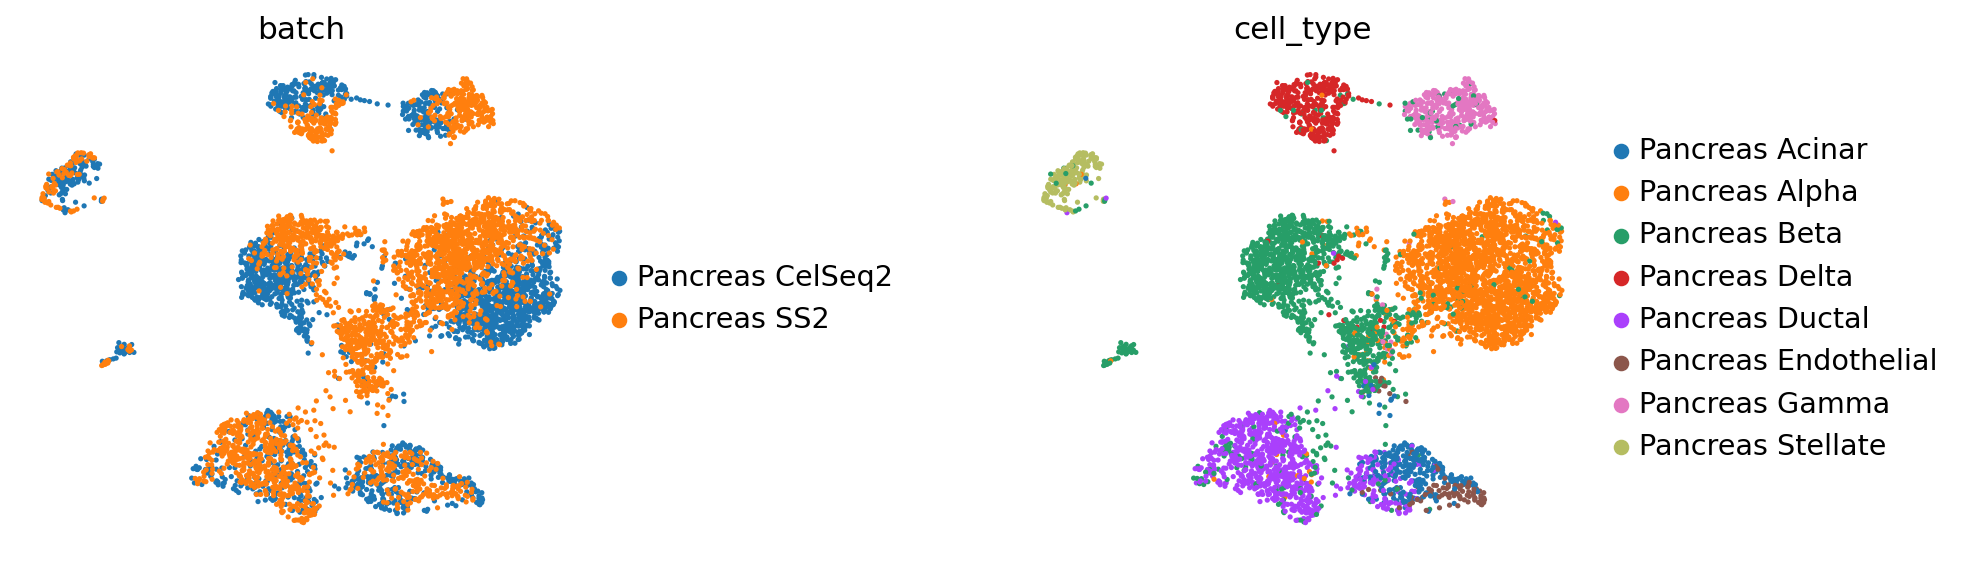

In [18]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [19]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

In [20]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obsm

AxisArrays with keys: 

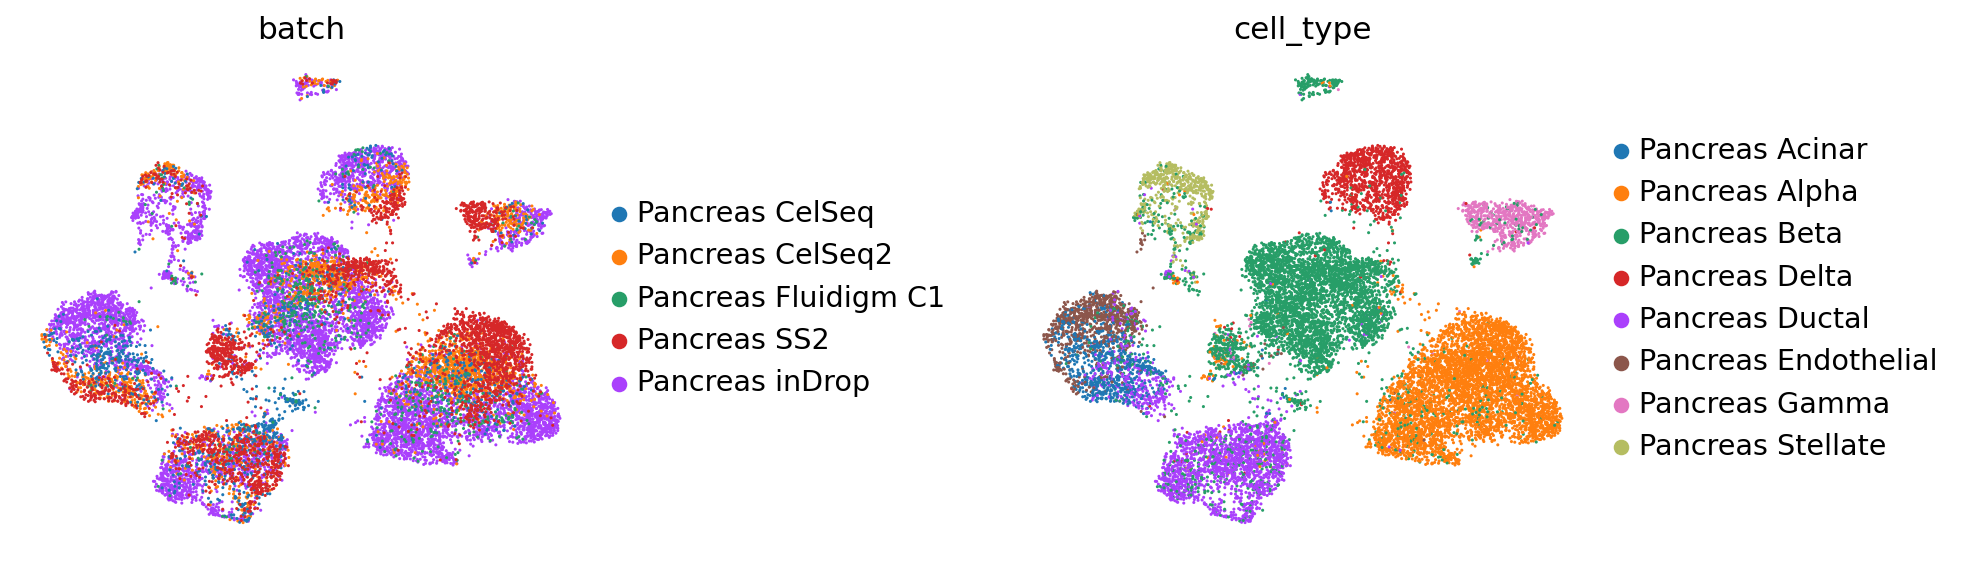

In [21]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [22]:
import scanpy as sc
import scib

In [ ]:
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
scib.metrics.graph_connectivity(full_latent, 'batch'), scib.metrics.graph_connectivity(full_latent, 'cell_type')

In [18]:
sc.tl.umap(full_latent)

In [19]:
scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')

mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.710508
Pancreas Alpha                0.864015
Pancreas Beta                 0.897339
Pancreas Delta                0.891119
Pancreas Ductal               0.859291
Pancreas Endothelial          0.814087
Pancreas Gamma                0.699826
Pancreas Stellate             0.788291


0.8155594348366265

In [46]:
scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')

0.6438113451004028

In [20]:
scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
#surgery results
# avg: 0.8431870919111784
# Pancreas Acinar: 0.6093845216331506
# Pancreas Alpha: 0.9557917109458023
# Pancreas Beta: 0.8404529655791008
# Pancreas Delta: 0.9641125121241515
# Pancreas Ductal: 0.8212983223924144
# Pancreas Endothelial: 0.761071623838163
# Pancreas Gamma: 0.9231927710843374
# Pancreas Stellate: 0.8701923076923077

#ewc results
# avg: 0.8225194550621739
# Pancreas Acinar: 0.5151739452257587
# Pancreas Alpha: 0.955857740585774
# Pancreas Beta: 0.8416208328656415
# Pancreas Delta: 0.9603060736489718
# Pancreas Ductal: 0.8208373904576437
# Pancreas Endothelial: 0.6738597351642963
# Pancreas Gamma: 0.9455676516329704
# Pancreas Stellate: 0.8669322709163346

#rehearsal results
# avg: 0.8482594519131934
# Pancreas Acinar: 0.5977157360406091
# Pancreas Alpha: 0.9642781203487135
# Pancreas Beta: 0.8414811500167804
# Pancreas Delta: 0.9661097852028638
# Pancreas Ductal: 0.82089914945322
# Pancreas Endothelial: 0.77526395173454
# Pancreas Gamma: 0.9503437738731857
# Pancreas Stellate: 0.8699839486356341

isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.5977157360406091


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.9642781203487135


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.8414811500167804


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.9661097852028638


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.82089914945322


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Endothelial: 0.77526395173454


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Gamma: 0.9503437738731857


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Stellate: 0.8699839486356341


0.8482594519131934

In [33]:
import pandas as pd
# methods_metrics = {'Bio_cons_ASW': [0.66, 0.65,0.68],
#                    'Batch_corr_ASW': [0.80, 0.79,0.82],
#                    'Bio_cons_graph_conn': [0.97,0.97,0.97],
#                    'Batch_corr_graph_conn': [0.76,0.85,0.73],
#                    'isolated_labels': [0.84, 0.82, 0.85]}
# index = ['Surgery', 'ewc', 'rehearsal']
# methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
# methods_metrics_df

methods_metrics = {'Surgery': [0.66,0.97,0.80,0.76,0.84], 
                   'ewc_0.1': []
                   'ewc_0.4': [0.65,0.97,0.79,0.85,0.82], 
                   'ewc_0.7':[],
                   'ewc_1': [],
                   'rehearsal': [0.68,0.97,0.82,0.73,0.85], 
                   'latent replay_1%': [],
                   'latent replay_10%': [],
                   'latent replay_50%': [],'Bio_cons_graph_conn'
                   'latent replay_100%': [],}
index = ['Bio_cons_ASW', 'Bio_cons_graph_conn', 'Batch_corr_ASW','Batch_corr_graph_conn','isolated_labels']
methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
methods_metrics_df

SyntaxError: invalid syntax (3490716869.py, line 13)

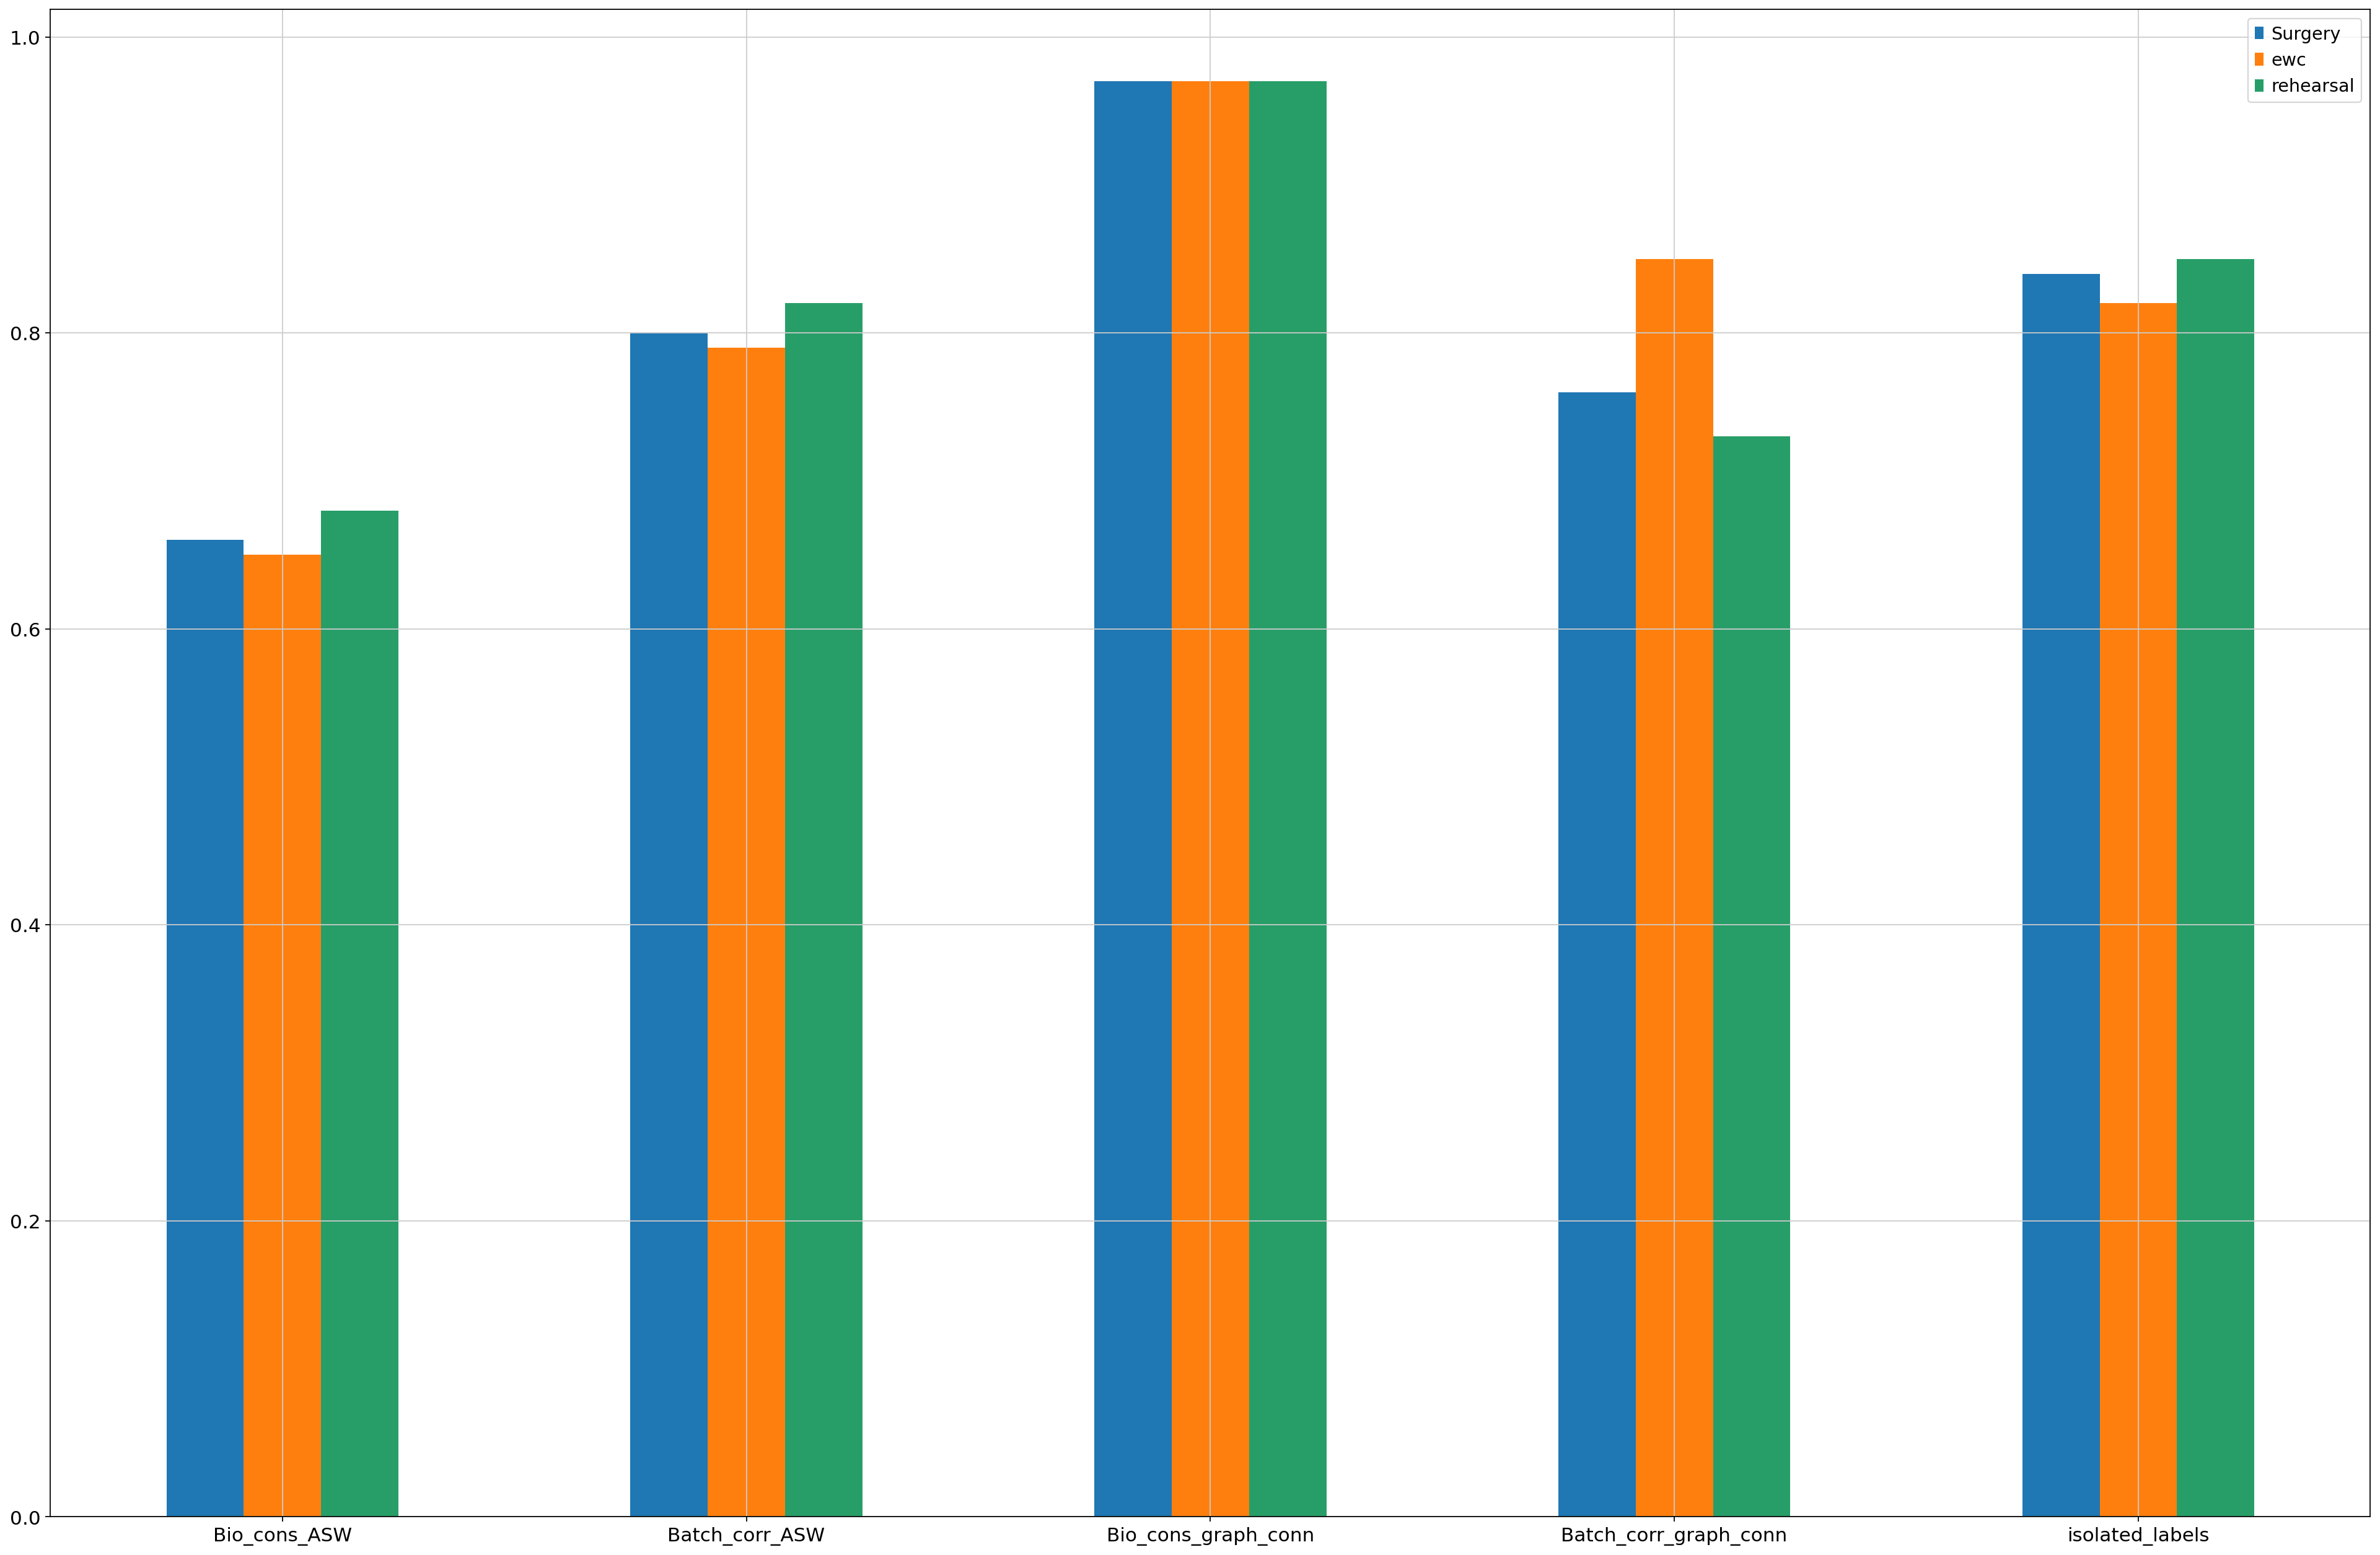

In [32]:
ax = methods_metrics_df.plot.bar(rot=0, figsize = (30,20))
# import matplotlib.pyplot as plt
# ax.set_xlabel(index, fontsize = 12)
#ax.set_ylabel('y-axis', fontsize = 10)

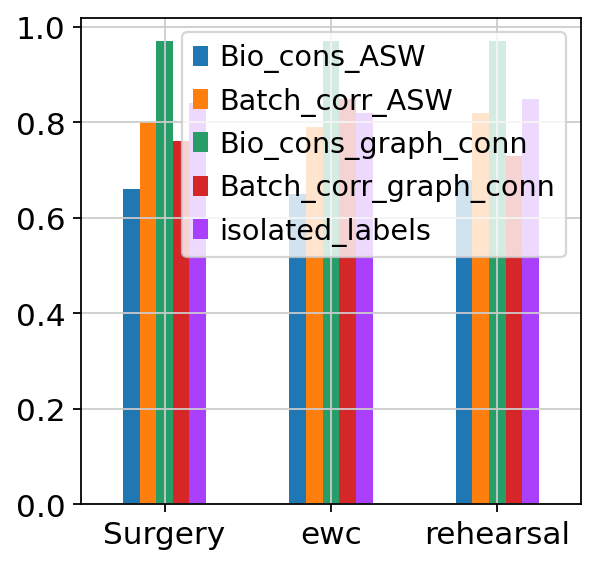

In [28]:
Bio_cons_ASW = [0.66, 0.65,0.68]
Batch_corr_ASW = [0.80, 0.79,0.82]
Bio_cons_graph_conn = [0.97,0.97,0.97]
Batch_corr_graph_conn = [0.76,0.85,0.73]
isolated_labels = [0.84, 0.82, 0.85]
index = ['Surgery', 'ewc', 'rehearsal']
df = pd.DataFrame({'Bio_cons_ASW': Bio_cons_ASW,
                   'Batch_corr_ASW': Batch_corr_ASW,
                   'Bio_cons_graph_conn': Bio_cons_graph_conn,
                   'Batch_corr_graph_conn': Batch_corr_graph_conn,
                   'isolated_labels': isolated_labels}, index=index)
ax = df.plot.bar(rot=0)